In [1]:
# import standard libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
import time 
import pandas as pd
from torch import nn
import collections
import progressbar
from progressbar import FormatLabel, Percentage, Bar, ETA
import h5py
import os

# import custom libraries
from data_loader import DataLoader, batch
from data_viewer import plotTraj, animatePreview, animateLoc, animateTraj, smooth
import hdf5_utils as hd
from simulation import Agent, Engine, get_mean_speed, get_density


# Setup matplotlib in interaction mode and load style sheet
%matplotlib notebook
plt.style.use("plotstyle.mplstyle")

# reload changes in libraries automaticly 
%load_ext autoreload
%autoreload 2

# set the random seed for reproducability
np.random.seed(42)

# TODO parameter dict for agent and fix start position bug

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting-Parameters-and-loading-dataset" data-toc-modified-id="Setting-Parameters-and-loading-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting Parameters and loading dataset</a></span></li><li><span><a href="#Format-training-data-as-tensors" data-toc-modified-id="Format-training-data-as-tensors-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Format training data as tensors</a></span></li><li><span><a href="#Define-Model" data-toc-modified-id="Define-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define Model</a></span></li><li><span><a href="#Train-model" data-toc-modified-id="Train-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train model</a></span></li><li><span><a href="#Check-on-test-set" data-toc-modified-id="Check-on-test-set-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Check on test set</a></span></li><li><span><a href="#Save/-Load-model" data-toc-modified-id="Save/-Load-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save/ Load model</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Simulation</a></span><ul class="toc-item"><li><span><a href="#Singel-agent" data-toc-modified-id="Singel-agent-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Singel agent</a></span></li><li><span><a href="#Multi-agent" data-toc-modified-id="Multi-agent-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Multi agent</a></span></li></ul></li><li><span><a href="#Additional-functionalities" data-toc-modified-id="Additional-functionalities-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Additional functionalities</a></span><ul class="toc-item"><li><span><a href="#Perform-measurements" data-toc-modified-id="Perform-measurements-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Perform measurements</a></span></li><li><span><a href="#Append-datasets" data-toc-modified-id="Append-datasets-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Append datasets</a></span></li><li><span><a href="#Insert-static-person" data-toc-modified-id="Insert-static-person-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Insert static person</a></span></li></ul></li></ul></div>

In this Notebook the whole wokflow of training and testing a network is shown. In the data folder some Models that are pretrained can be found. If you do not want to train a network you may skip the step 4-5. But keep in minde to initalize the parameter dict and load the dataset even if you load an existing model. 


# Setting Parameters and loading dataset

First we define the parameters for the model and dataset preprocessing. The notebook uses CUDA GPU support if you don't have a system with cuda support you have to set the torch device in the parameter dict to cpu.

In [2]:
# give each dataset a unique index so we can perform scans
scan = {"ug-180-015":0,
        "ug-180-030":1,
        "ug-180-060":2,
        "ug-180-085":3,
        "ug-180-095":4,
        "ug-180-110":5,
        "ug-180-140":6,
        "ug-180-230":7,
       }

# allow the loading of existing HDF 5 for the exact same parameters 
# if it is false the trajecories are extracted every time which is slower
load_traindata = True

# Set here the parameters for the I/O of the model
dset = {'neighbors':6,
        'ret_vel':True,
        'nn_vel': True,
        'truth_with_vel': True,
        'shuffle':True,
        'mode': "wrap",
        'step_nr':1,
        'downsample':8,
        'fps':16,
        'name':  "ug-180-095"  #"ao-360-400_combine"
       }
# availiabel person for a width of 180: 15, 30, 60, 85, 95 110, 140, 230

# Set the parametes for the model and the hyperparameters
param = {'input_s': 2+2*dset['ret_vel']  + dset['neighbors']*(2+2*dset['nn_vel']), #(number_nei+1)*4,
         'hidden_s': [32, 32, 64, 128, 128, 40],# EPFL trafic network
         'output_s': 2+dset['truth_with_vel']*2,
         'epochs':30,
         'batch_size':10,
         'lr':1e-3,
         'decay':0.1,
         'decay_step':5,
         'device':torch.device("cuda:0"), #"cuda:0" or "cpu" if no cuda GPU is available
         'dataset':dset,
        }



# Path to datasets  choose between Bottleneck and corridor
#PATH = "../../other/AO/"
PATH = "../../other/UG/UG-roh_nachkorrigiert/"

#Outputpaths
PATH2 = "data/HD5/"
PATH_M = "data/model/"
PATH_O = "data/Output/test_scan/"

Now we can load a dataset from the given path. We want to get the training, validatan and testing data. The first time for a given dataset and parameters we extract all trajectories and convert them to the training input/truth pairs. In order to save time we store the created splits as a HDF5 file. If the same dataset was already used with the same settings we load it directly from the HDF5 File, which is faster.

In [3]:

ds = DataLoader(PATH + dset['name'] + ".txt")

ds.load()

print("Persons: ", ds.data.p.max())
print("Frame maximum :", ds.data.f.max() )

# generate filename encoding the parameters
sufix = "_nn{}_s{}_vr{}_m{}_vi{}_st{}_d{}".format(dset['neighbors'],
                                 dset['shuffle'],
                                 dset['truth_with_vel'],
                                 dset['mode'],
                                 dset['ret_vel']+dset['nn_vel'], 
                                 dset['step_nr'],
                                 dset['downsample'])

# generate filenmae at export direcotry
f_name = PATH2+param['dataset']['name']+sufix+'.h5'

# if file exsists we load it tor reduce computation time
if os.path.isfile(f_name) and load_traindata:

    train, val, test, param['dataset'] = hd.load_trainingdata(f_name)
    scan_idx = scan[param['dataset']['name']]
    print("Trainingdata has been loaded")
    
else: # we never used the dataset with the given parameters or we want to recompute the trajectories
    # here we could select data augmentation to get more training samples 
    f_x = ds.flip_x
    augmentation = []# [f_x]
    
    # use the functionality of the dataloader to get the train/test split
    train, val, test = ds.get_train_data(dset['neighbors'], 
                                         step_nr=dset['step_nr'],
                                         downsample=dset['downsample'],
                                         augmentation=augmentation,
                                         ret_vel=dset['ret_vel'],
                                         nn_vel=dset['nn_vel'],
                                         shuffle=dset['shuffle'],
                                         truth_with_vel=dset['truth_with_vel'],
                                         mode=dset['mode'])
    # Fill the rest of the parameters
    dset['date'] = time.ctime()
    dset['creator'] = 'zehndiii'
    dset['augmentation'] = str(augmentation)
    param['dataset'] = dset
    
    # save the training data in the output folder
    hd.save_trainingdata(f_name, param, train, val, test)
    scan_idx = scan[param['dataset']['name']]
    print("Training data saved to : {}".format(PATH2+f_name+sufix+'.h5'))

loaded 364 persons
Persons:  364
Frame maximum : 3770
Trainingdata has been loaded


In [67]:
# check the parameter of a given file and its dimentions. 
hd.print_stats(PATH2+param['dataset']['name']+sufix+'.h5')

File: data/HD5/ug-180-095_nn6_sTrue_vrTrue_mwrap_vi2_st1_d8.h5/
|     Size: 18.17MB
|     @augmentation: []
|     @creator: zehndiii
|     @date: Tue Nov 24 23:18:38 2020
|     @downsample: 8
|     @fps: 16
|     @mode: wrap
|     @name: ug-180-095
|     @neighbors: 6
|     @nn_vel: True
|     @ret_vel: True
|     @shuffle: True
|     @step_nr: 1
|     @truth_with_vel: True
|
|Group: test 
|     |-----Dataset: input           - Shape: (29968, 28) float32
|     |-----Dataset: truth           - Shape: (29968, 4) float32
|
|Group: train 
|     |-----Dataset: input           - Shape: (89905, 28) float32
|     |-----Dataset: truth           - Shape: (89905, 4) float32
|
|Group: val 
|     |-----Dataset: input           - Shape: (29969, 28) float32
|     |-----Dataset: truth           - Shape: (29969, 4) float32


# Format training data as tensors

In order to use the data with PyTorch we need to transform the data to a pytorch tensor. We send the tensors to an Nvidia GPU if available. 

In [4]:


t_input, t_truth = train
v_input, v_truth = val
test_input, test_truth = test


if param['dataset']['name']=='all':
    p = np.random.permutation(len(t_truth))
    #np.random.shuffle(steps_input)
    print("extra shuffeling")
    t_input = t_input[p]
    t_truth = t_truth[p]
    

t_i = torch.from_numpy(t_input).to(param['device']).float()
t_t = torch.from_numpy(t_truth).to(param['device']).float()

v_i = torch.from_numpy(v_input).to(param['device']).float()
v_t = torch.from_numpy(v_truth).to(param['device']).float()

test_i = torch.from_numpy(test_input).to(param['device']).float()
test_t = torch.from_numpy(test_truth).to(param['device']).float()




# Define Model

We define the model architecture as a class which is derived from the torch.nn.Module class. We pass the network size as parametrs which allows us to switch easily between different architectures.

In [7]:


# Fully connected neural network with five hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc_in = nn.Linear(input_size, hidden_size[0]) 
        
        #self.fc_hidden = []
        #for i in range(len(hidden_size)-1):
        self.fc_hidden_1 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc_hidden_2 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc_hidden_3 = nn.Linear(hidden_size[2], hidden_size[3])
        
        self.fc_hidden_4 = nn.Linear(hidden_size[3], hidden_size[4])
        self.fc_hidden_5 = nn.Linear(hidden_size[4], hidden_size[5])

        
        self.fc_out = nn.Linear(hidden_size[-1], output_size)
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
     
        out = self.relu(self.fc_in(x))
        
        #for i in range(len(self.fc_hidden)):
        #    out = self.relu(self.fc_hidden[i](out))
        
        out = self.relu(self.fc_hidden_1(out))
        out = self.relu(self.fc_hidden_2(out))
        out = self.relu(self.fc_hidden_3(out))
        out = self.relu(self.fc_hidden_4(out))        
        out = self.relu(self.fc_hidden_5(out))

        
        out = self.fc_out(out)
        return out

# we create an instance of the model and send it to the specified device eg GPU or CPU
model = NeuralNet(param['input_s'], param['hidden_s'], param['output_s']).to(param['device'])


Now we define the loss function, optimizer and a learning rate scheduler. The lr scheduler allows us to reduce the learning rate over the training epochs so we can start with a bigger lr and still find a good minima in the end. 

In [6]:

loss_fn = nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=param['decay_step'], gamma=param['decay'])


# Train model

Now we can start the training loop. We shuffle the training data in every epoch than we pass the data in baches through the netork an do an optimization after every batch. At the end of an epoch we compute the loss on the validation set in order to verify that the network is learning and not overfitting.

In [7]:

d_len = t_i.shape[0]

# initialize a progressbar
pbar = progressbar.ProgressBar(max_value=param['epochs'])
widgets = [FormatLabel(''), ' ', Percentage(), ' ', Bar(), ' ', ETA()]
pbar = progressbar.ProgressBar(widgets=widgets, maxval=param['epochs']*d_len)
pbar.start()

# initialize array to keep loss
training_loss = []
validation_loss = [np.inf] # wee need a first value for the progress bar

for t in range(param['epochs']):
    
    # shuffle data
    p = np.random.permutation(len(t_i))
    t_i = t_i[p]
    t_t = t_t[p]
    
    # iterate over all batches
    for  y, (t_i_b, t_t_b) in  enumerate(batch(t_i, t_t, param['batch_size'])):
        y_pred = model(t_i_b)           # run the forward pass through the model
       
        loss = loss_fn(y_pred, t_t_b)   # compute the loss

        model.zero_grad()               # reset grads
       
        loss.backward()                 # compute correction

        optimizer.step()                # do an optimizer run
        
        # update pbar
        widgets[0] = FormatLabel('loss(t/v) : {:.4} / {:.4} | lr={:.4}'.format(loss.item(),
                                                                            validation_loss[-1],
                                                                            optimizer.param_groups[0]['lr']))
        pbar.update(t*d_len+y*param['batch_size'])
        
        if y%10==9: # store train loss every 10 batches
            training_loss += [loss.cpu().detach().numpy()]
    
    # Test on validation
    loss = []
    with torch.no_grad():
        for v_i_b, v_t_b in batch(v_i, v_t, param['batch_size']):
            y_pred = model(v_i_b)
            loss += [loss_fn(y_pred, v_t_b).cpu().detach().numpy()]
            pbar.update()
    validation_loss.append( np.array(loss).mean() )
    
    scheduler.step()
        

pbar.finish()




loss(t/v) : 41.68 / 114.3 | lr=1e-08 100% |####################| Time:  0:22:18


<IPython.core.display.Javascript object>


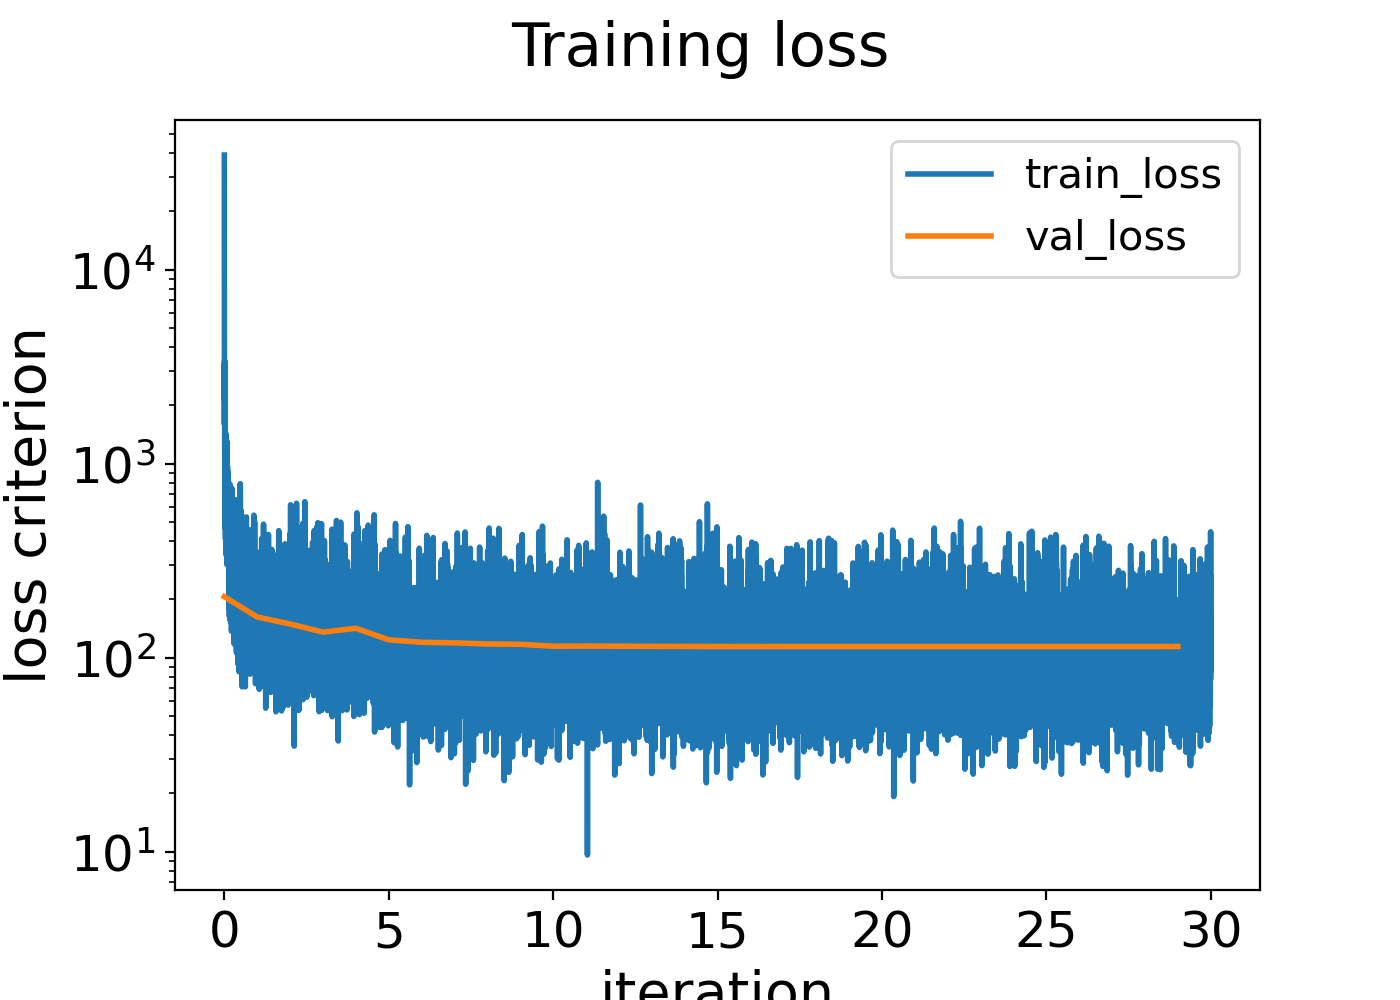

In [8]:
%matplotlib notebook
# convert to np arrays
train_loss = np.array(training_loss)
val_loss = np.array(validation_loss[1:])

plt.figure()
plt.semilogy(np.arange(len(train_loss))*10*param['batch_size']/d_len, train_loss, label="train_loss")
plt.semilogy(np.arange(len(val_loss)), val_loss, label="val_loss" )
plt.xlabel("iteration")
plt.ylabel("loss criterion")
plt.suptitle("Training loss")
plt.legend()
plt.show()


In [9]:
# set the model to evaluation mode 
mod = model.eval()



# Check on test set

Run a benchmark on the test set.

100% (29968 of 29968) |##################| Elapsed Time: 0:00:19 Time:  0:00:19


<IPython.core.display.Javascript object>


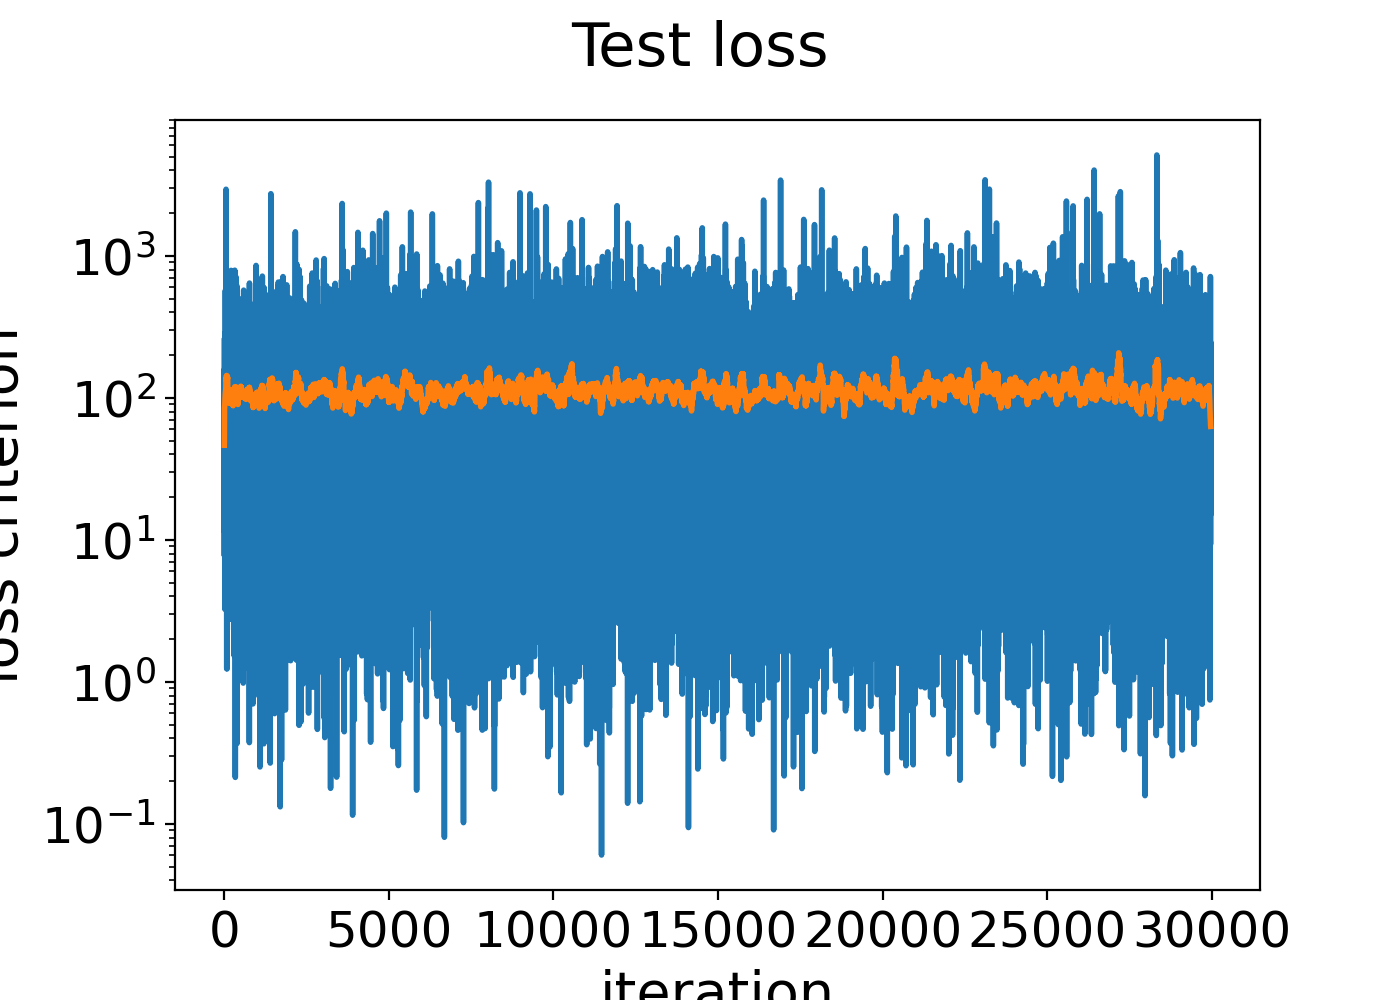

In [10]:

test_dat = []

pbar = progressbar.ProgressBar(maxval=len(test_i))
pbar.start()

i = 0

with torch.no_grad():
    for (ti, tt) in zip(test_i, test_t):
        pred = model(ti)
        loss = loss_fn(pred, tt)
        test_dat.append(loss.cpu().detach().numpy())
     
        if i%10:
            pbar.update(i)
        
        i += 1
        
    pbar.finish()
    
test_dat = np.array(test_dat)

# save mean test loss
param['mtl'] = test_dat.mean()

plt.figure()
plt.semilogy(np.arange(len(test_dat)), test_dat)
plt.semilogy(np.arange(len(test_dat)), smooth(test_dat, 100))
plt.xlabel("iteration")
plt.ylabel("loss criterion")
plt.suptitle("Test loss")
plt.show()

# Save/ Load model

We create the model name with the following convention. Then we save or load the models to/from the HDF5 file. Use the msg tag to add a comment to the model.

In [8]:

#name = "model_UG_downsample_good_"
#name = "model_phaseplott_v2_"
name = "model_phaseplott_with_all_v2_"
#name = "test_model"

# sufix used for model tests
suffix_m = "_nn{}_vel{}{}_{}_s{}_{}_{}_e{}_lr{}".format(param['dataset']['neighbors'],
                                                         param['dataset']['ret_vel'],param['dataset']['nn_vel'],param['dataset']['truth_with_vel'],
                                                         param['input_s'],param['hidden_s'],param['output_s'],
                                                         param['epochs'],
                                                         param['lr'],
                                                       )

# for test we do not need a suffix
#suffix_m = ""

#f_name = PATH_M+name+"sweep_vel.h5"
f_name = PATH_M+name+suffix_m+".h5"    

f_name

'data/model/model_phaseplott_with_all_v2__nn6_velTrueTrue_True_s28_[32, 32, 64, 128, 128, 40]_4_e30_lr0.001.h5'

In [12]:
# add here a comment to the dataset
param['msg'] = "second run"

#prefix = "model_nn{}_2".format(param['dataset']['neighbors'])
prefix="model_1"

# save the model 
hd.save_torch(model, optimizer, f_name, param, prefix=prefix, scan=True)

In [9]:
model_name = "model_1"

# load the dataset and set mode to eval
# replace None with "cpu" / "cuda:0" if model was trained on different device
model , param = hd.load_torch(f_name, NeuralNet, prefix=model_name, change_dev="cpu")
mod = model.eval()


In [6]:
# look at the parameters from the given model

hd.print_stats(f_name)

File: data/model/model_phaseplott_with_all_v2__nn6_velTrueTrue_True_s28_[32, 32, 64, 128, 128, 40]_4_e30_lr0.001.h5/
|     Size: 185.09KB
|     @mode: multi_model
|     @models: [b'dummy' b'model_1']
|
|Group: model_1 
|     @batch_size: 10
|     @creator: zehndiii
|     @date: Sat Nov 28 22:14:29 2020
|     @decay: 0.1
|     @decay_step: 5
|     @device: cuda:0
|     @epochs: 30
|     @lr: 0.001
|     @mode: single_model
|     @msg: No augementation 
|     |
|     |Group: dataset 
|     |     @augmentation: []
|     |     @creator: zehndiii
|     |     @date: Sat Nov 28 20:03:01 2020
|     |     @downsample: 8
|     |     @fps: 16
|     |     @mode: wrap
|     |     @name: all
|     |     @neighbors: 6
|     |     @nn_vel: True
|     |     @ret_vel: True
|     |     @shuffle: True
|     |     @step_nr: 1
|     |     @truth_with_vel: True
|     |
|     |Group: model 
|     |     @hidden_s: [ 32  32  64 128 128  40]
|     |     @input_s: 28
|     |     @layers: ['fc_in.weight' 'fc_in.bi

# Simulation 

## Singel agent

We replace a single person with an agent to test the network.

In [75]:
AGENT_OFFSET = 1000
# give person id we want to replace with agent
test_person = 10

# copy dataset object so we can remove peoople
da = DataLoader(None)
da.copy(ds)

# get person data to use as inital condidion and remove it
frames_o, pos_vel_o = da.person(test_person, )
da.remove_person(test_person)

# create agent
agent = Agent(model,
              pos_vel_0=pos_vel_o[0],
              frame_0=frames_o[0],
              param=param,
              id=AGENT_OFFSET+test_person )

# create simulation object
sim = Engine(da, agents=[agent],
             stop_agent=True,
             xlim = 400, 
             param = param,
             truth=ds
            )

# run the simulation 
sim.run(1, 1000)#frames_o[-1], )

# copy simulated date to print
dp = DataLoader(None)
dp.copy(sim.ds)

# save the results and includ original data for measurements
do = sim.save(name=PATH_O+"single_agent", include_truth=True)



sim from : 1 to 1000


Done! 100% |###################################################| Time:  0:00:08


Warning! Only new IDs are considered.


<IPython.core.display.Javascript object>


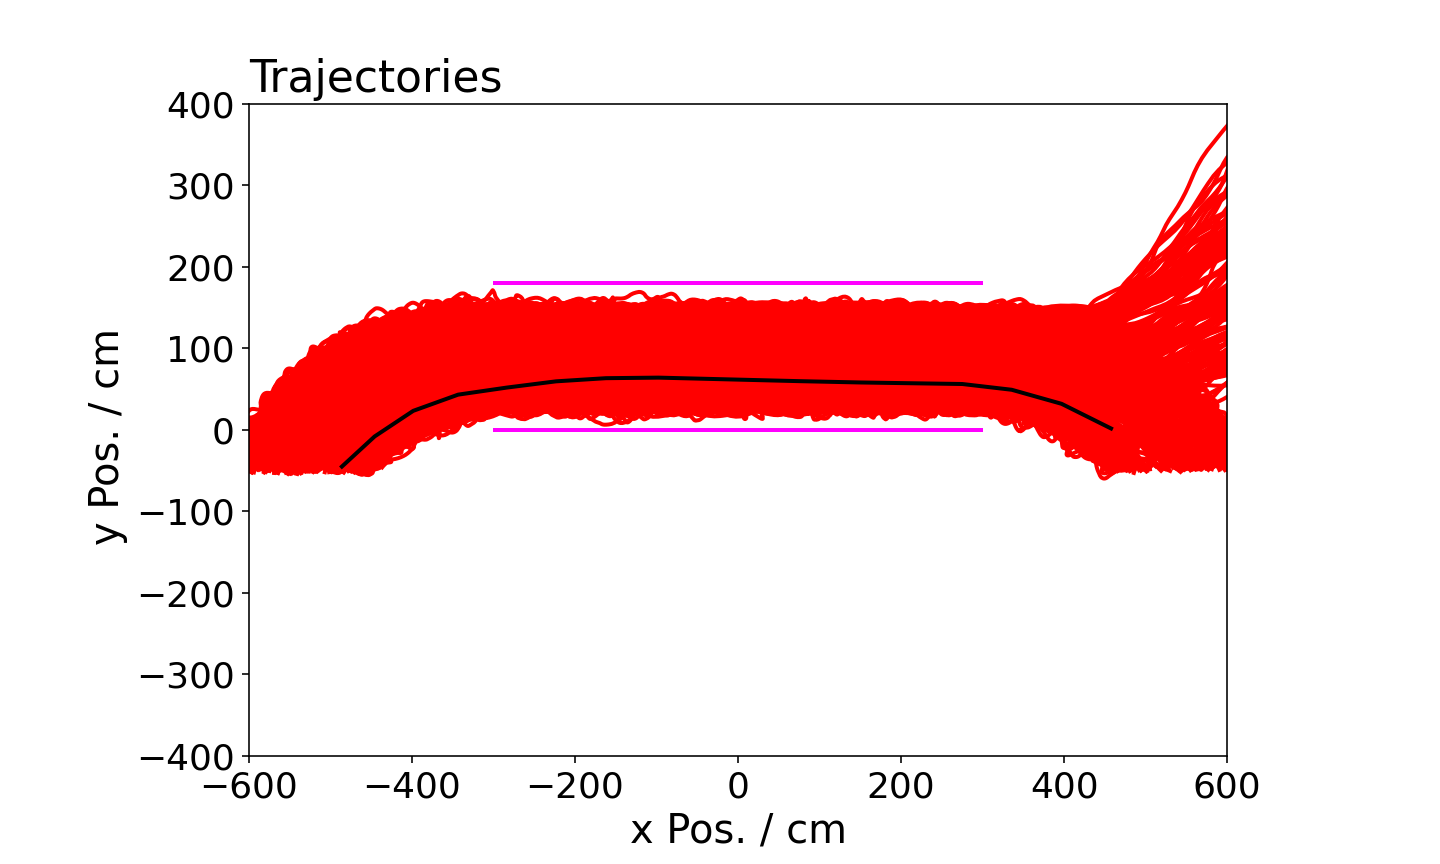

In [76]:
%matplotlib notebook
# create trajectory plot and indicate the agent in black
plotTraj(dp,  boundaries=[-600, 600, -400, 400],
         people=None,
         ai=[ AGENT_OFFSET+test_person],
         legend=False, cor=True,
         title="Trajectories",
         path=PATH_O+"trajectory_singe_agent.png",
         save=True)

In [53]:
%matplotlib inline
# create movie with locations
ani = animateLoc(dp, frame_start=frames_o[0], frame_stop=frames_o[-1],ai=[AGENT_OFFSET+test_person],
             boundaries=[-800, 600, -200, 400], step=2, fps=16, 
            title=r"Corridor - {} ".format(param['hidden_s'][0]), save=True,
             path=PATH_O+"single_agent_all_set_{}.gif".format(param['dataset']['name']), cor=True,
             )
display(ani)

## Multi agent 

Replace multiple or evan all people with agents. We first read the initial positions from the originall dataset and remove the person afterwards. We simulate agents with id greater than AGENT_OFFSET to be compatible with the measurement code. Simulation may take several minutes.

In [10]:
AGENT_OFFSET = 1000

da = DataLoader(None)
da.copy(ds)

# cut the first 250 frames in order to get a more stable time intervall
da.data = da.data[ da.data['f']>250]
frames = da.data['f'].unique()

# set which people to replace with agents
#agents_id = np.array([10, 13, 16,  20, 22, 26,  30, 35, 40, ]) 
agents_id = da.data['p'].unique() # replace all person with agents

agents = []
frame_max = 0

# iterate over all agents ant initialize them with a good starting position
for j, test_person in enumerate(agents_id):

    frames_o, pos_vel_o =  da.person( test_person, )
    da.remove_person(test_person)
        
    if len(frames_o)<1:# if person tracectory is empty we do not append the agent
        continue
    
    frame_max = max(frames_o[-1], frame_max) # keep the maximum frame to rednder
    
    agents += [Agent(model,
                     pos_vel_0=pos_vel_o[0],
                     frame_0=frames_o[0],
                     param=param,
                     id=AGENT_OFFSET+test_person )]


    # add three personsn evenly spaced in the middle of the corridor
traj = np.zeros( (frames.shape[0], 2) )
vels = traj.copy()
print(traj.shape)
traj[:, 0] = -100
traj[:, 1] = 90

da.append_person(AGENT_OFFSET-1, frames, traj, vel=vels)
    

traj = np.zeros( (frames.shape[0], 2) )
vels = traj.copy()
print(traj.shape)
traj[:, 0] = 100
traj[:, 1] = 90

da.append_person(AGENT_OFFSET-2, frames, traj, vel=vels)
    
traj = np.zeros( (frames.shape[0], 2) )
vels = traj.copy()
print(traj.shape)
traj[:, 0] = 0
traj[:, 1] = 90

da.append_person(AGENT_OFFSET-3, frames, traj, vel=vels)
    
    
print("People in Dataset: ", da.persons)
print("Agents in Dataset: ", len(agents))
print("Frame max: ", frame_max)

# create simulation engine
sim = Engine(da,
             agents=agents,
             param=param,
             stop_agent=True,
             xlim=350,
             truth=ds
            )

# run simulation
sim.run(0,frame_max, )


# Dataset for plotting
dp = DataLoader(None)
dp.copy(sim.ds)


# save the results and include original data for comparison
#PATH_O+"multi_agent"
do = sim.save( name="data/Output/nn_scan/"+prefix+"_2", include_truth=True )
print("saved!")

plotTraj(dp,  boundaries=[-600, 600, -400, 400],
         people=None,cor=True,
         ai=agents_id+AGENT_OFFSET,
         legend=False,
         title="Trajectories",
         path=PATH_O+"trajectories_m_w.png",
         save=True)



(3520, 2)
(3520, 2)
(3520, 2)
People in Dataset:  3
Agents in Dataset:  347
Frame max:  3770
sim from : 0 to 3770


Done! 100% |###################################################| Time:  0:14:51


NameError: name 'prefix' is not defined

<IPython.core.display.Javascript object>


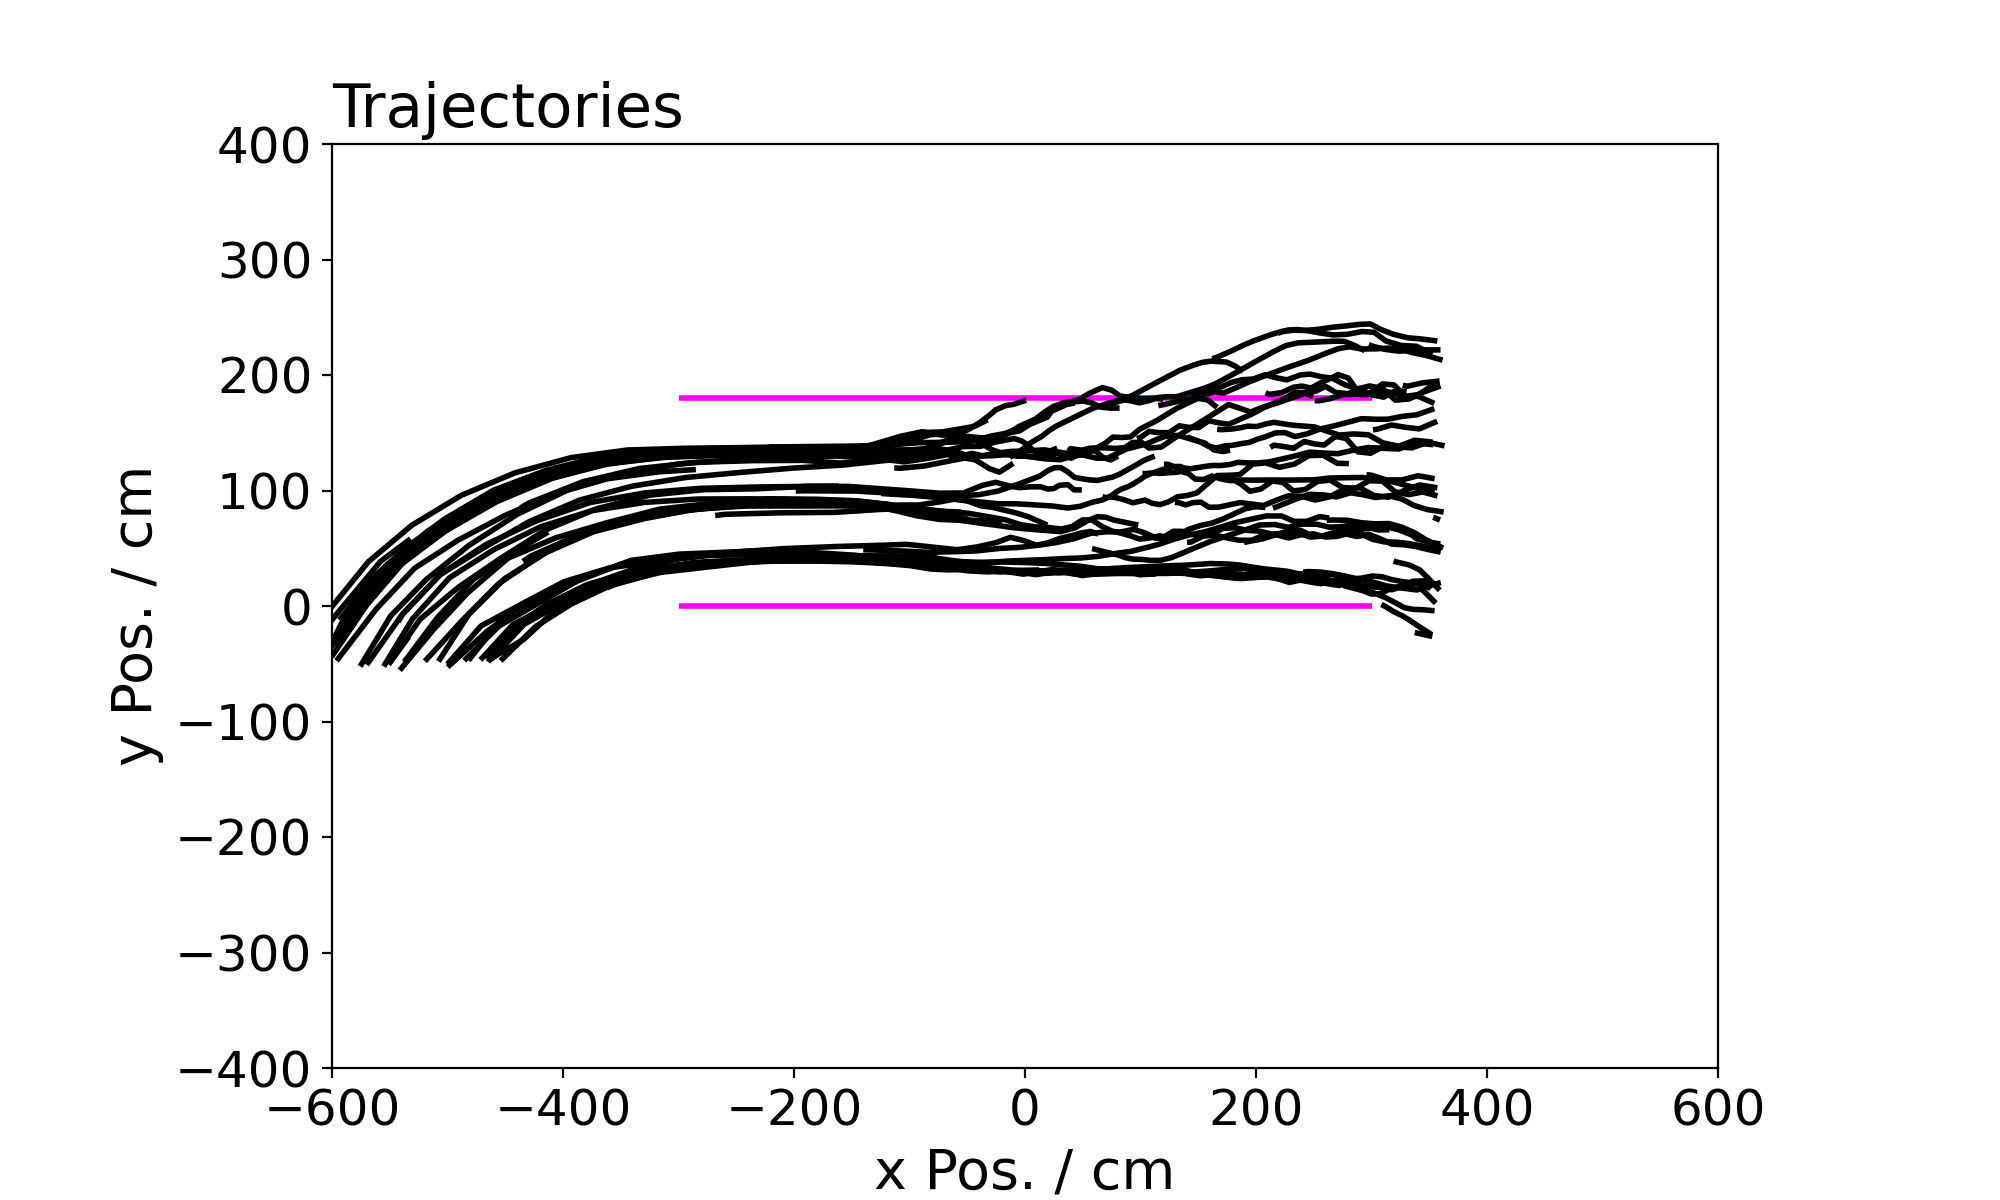

In [28]:
dp = DataLoader("data/Output/export_wall.csv")
dp.load()

dp.data = dp.data[ dp.data['f'] > 750]
dp.data = dp.data[ dp.data['f'] < 950]
dp.data = dp.data[dp.data['p']>AGENT_OFFSET]

plotTraj(dp,  boundaries=[-600, 600, -400, 400],
         people=None,cor=True,
         ai=agents_id+AGENT_OFFSET,
         legend=False,
         title="Trajectories",
         path=PATH_O+"trajectories_m_w.png",
         save=True)

In [121]:
# quick preview of the simulation to finde a good interval for measuremnts
dp.data = dp.data.sort_values('f')
animatePreview(dp, boundaries=[-600, 600, -250, 200], step=1)

In [12]:
%matplotlib inline
# create movie with locations
ani = animateLoc(dp, frame_start=300, frame_stop=frames_o[-1],ai=[AGENT_OFFSET+agents_id],
             boundaries=[-800, 600, -200, 400], step=2, fps=16, 
            title=r"Corridor - {} ".format(param['hidden_s'][0]), save=True,
             path=PATH_O+"tree_fix_095init_pos_sim.gif".format(param['dataset']['name']), cor=True,
             )
display(ani)

<IPython.core.display.Javascript object>


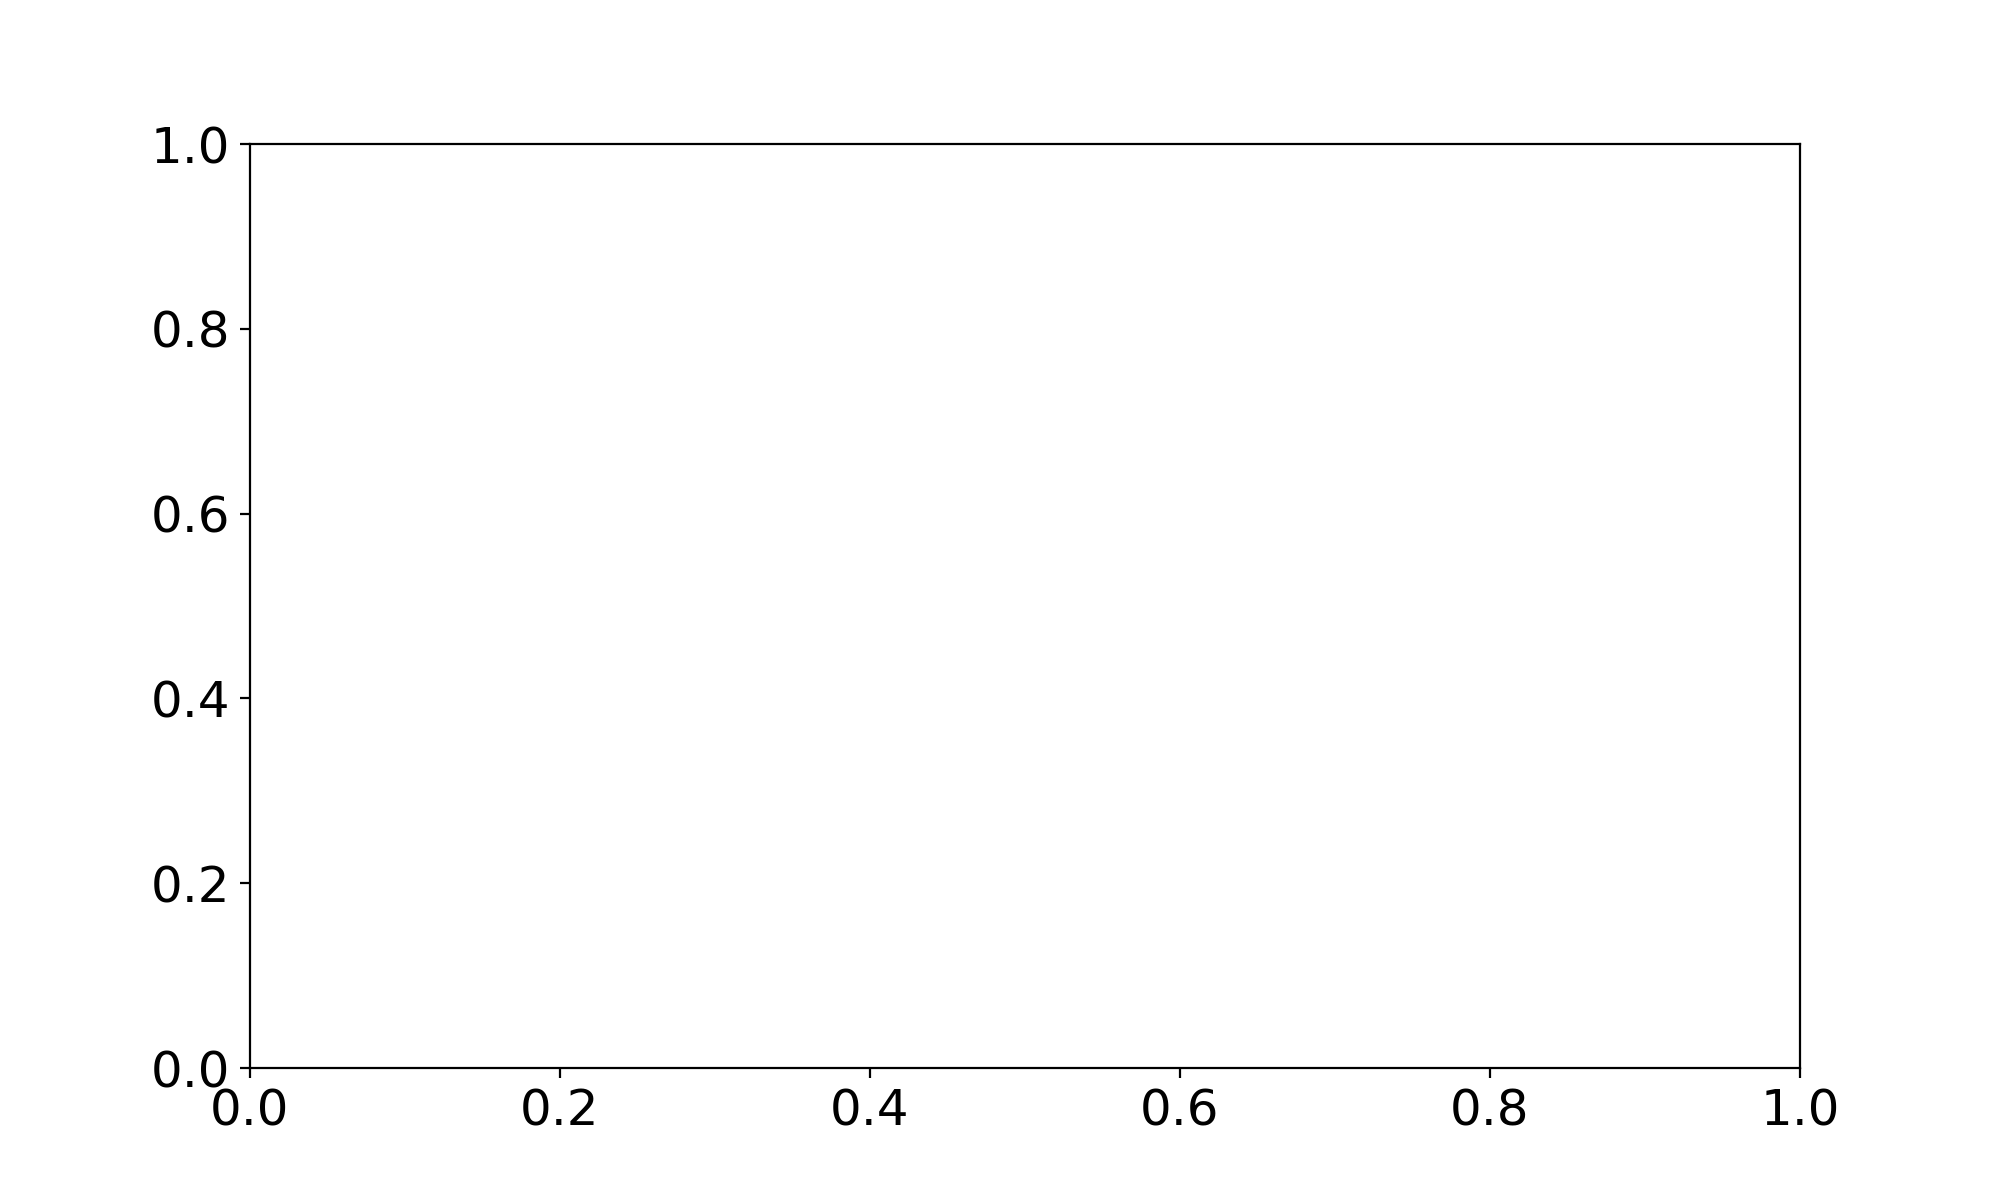

TypeError: unhashable type: 'numpy.ndarray'

In [15]:
%matplotlib notebook
# create trajectory plot and indicate the agent in black
#dp.data = dp.data[ dp.data['f'] > ]
#dp.data = dp.data[ dp.data['f'] < ]
plotTraj(dp,  boundaries=[-600, 600, -400, 400],
         people=None,
         ai=[ AGENT_OFFSET+agents_id],
         legend=False, cor=True,
         title="Trajectories",
         path=PATH_O+"trajectory_singe_agent.png",
         save=True)

# Additional functionalities

## Perform measurements

We need a dataset that contains both agent and person data. We first split it up and only look at a measurement interval and a region of iterest. We then get the density for every frame and the mean speed for every agent/ person. 

In [29]:

# create copy of dataset with 
dataset = DataLoader(None)
dataset.copy(do)

# set Measurement Parameters
roi=((-200, 180),(200, 0))

#15,    30,  60,  85,   95, 110,  140,  230 
#1070, 360, 480, 600,  800, 1000,  600, 250
#.                    500   500 ,  300. 250
m_len = 50         # length of measuremnt in frames
start_f = 500      # start frame
stop_f = start_f + m_len

# truncate dataset to measurement interval
dataset.data = dataset.data[ dataset.data['f']>=start_f]
dataset.data = dataset.data[ dataset.data['f']<stop_f]

dataset_p = DataLoader(None)
dataset_a = DataLoader(None)
dataset_p.copy(dataset)
dataset_a.copy(dataset)

# split the dataset in agent and people
dataset_p.data = dataset_p.data[ dataset_p.data['p']<AGENT_OFFSET]
dataset_a.data = dataset_a.data[ dataset_a.data['p']>=AGENT_OFFSET]

# get frames and ids for poth datasets
frames_p = dataset_p.data['f'].unique() 
frames_a = dataset_a.data['f'].unique() 

pers_id = dataset_p.data['p'].unique()
agent_id = dataset_a.data['p'].unique()


# initialize arrays
density_p = np.zeros_like(frames_p, dtype=np.float )
density_a = np.zeros_like(frames_a, dtype=np.float )

velocity_p = np.zeros_like(pers_id, dtype=np.float)
velocity_a = np.zeros_like(agent_id, dtype=np.float)


# measure densities on every frame
for i, f in enumerate(frames_p):
    density_p[i] = get_density(dataset_p, f, roi )
    
for i, f in enumerate(frames_a):
    density_a[i] = get_density(dataset_a, f, roi )

# measure velocities 
for j, p in enumerate(pers_id):
    velocity_p[j] = get_mean_speed(dataset_p, p, roi=roi, mode="both", normalize=False)

for j, p in enumerate(agent_id):
    velocity_a[j] = get_mean_speed(dataset_a, p, roi=roi, mode="both", normalize=False)

# convert to meters
to_m = 100
to_m2 = 100*100

# get the mean values and the error for the densities
density_pers = density_p.mean() * to_m2
density_pers_err = density_p.std(ddof=1) * to_m2

density_agent = density_a.mean() * to_m2
density_agent_err = density_a.std(ddof=1) * to_m2


# get the mean values and the error for the speed
velocity_pers = np.nanmean( velocity_p) / to_m
velocity_pers_err = np.nanstd( velocity_p, ddof=1) / to_m

velocity_agent = np.nanmean(velocity_a) / to_m
velocity_agent_err = np.nanstd(velocity_a, ddof=1) / to_m

print("Density Person: ", density_pers, "+/-", density_pers_err)
print("Density Agent: ",density_agent, "+/-", density_agent_err)

print("Velocity Person: ",velocity_pers, "+/-", velocity_pers_err)
print("Velocity Agent: ",velocity_agent, "+/-", velocity_agent_err)



Density Person:  0.14210526315789476 +/- 0.03077200290177613
Density Agent:  0.17236842105263162 +/- 0.05621840762683526
Velocity Person:  1.1457940094965064 +/- 0.08793642143123317
Velocity Agent:  1.0355644064181129 +/- 0.058073467294340333


We save all measurements to a numpy file and use the dataset name to create an index. Create movies of the measurement simulation and the truth. And graph a preview of the measured points.

In [30]:
# define outputfile
output = PATH_O+"scan_test.npy"

# create empty np array if the file does not exist otherwise load the file
if os.path.isfile(output):
    scan = np.load(output)
else:
    scan = np.zeros((len(scan), 8))

# add the measurement data
scan[scan_idx] = [density_pers, density_pers_err, density_agent, density_agent_err,
                  velocity_pers, velocity_pers_err, velocity_agent, velocity_agent_err]

# save the np.array
np.save(output, scan)

In [31]:
%matplotlib inline
# create movie from agents
ani = animateLoc(dataset_a, frame_start=start_f, frame_stop=stop_f,ai=agents_id+AGENT_OFFSET,
             boundaries=[-600, 500, -200, 300], step=1, fps=16,
             title=r"Corridor - {} - $\varrho$={:.3}".format( param['hidden_s'], density_agent), save=False,
             path=PATH_O+"all_agents_all_set{}.gif".format(param['dataset']['name']), cor=True)

display(ani)

In [32]:
%matplotlib inline
# create movie from truth
ani = animateLoc(dataset_p, frame_start=start_f, frame_stop=stop_f,ai=None,
             boundaries=[-600, 500, -200, 300], step=1, fps=16,
             title=r"Corridor - {} - $\varrho$={:.3}".format(param['hidden_s'], density_pers), save=False,
             path=PATH_O+"truth_all_set_{}.gif".format(param['dataset']['name']), cor=True)

display(ani)

<IPython.core.display.Javascript object>


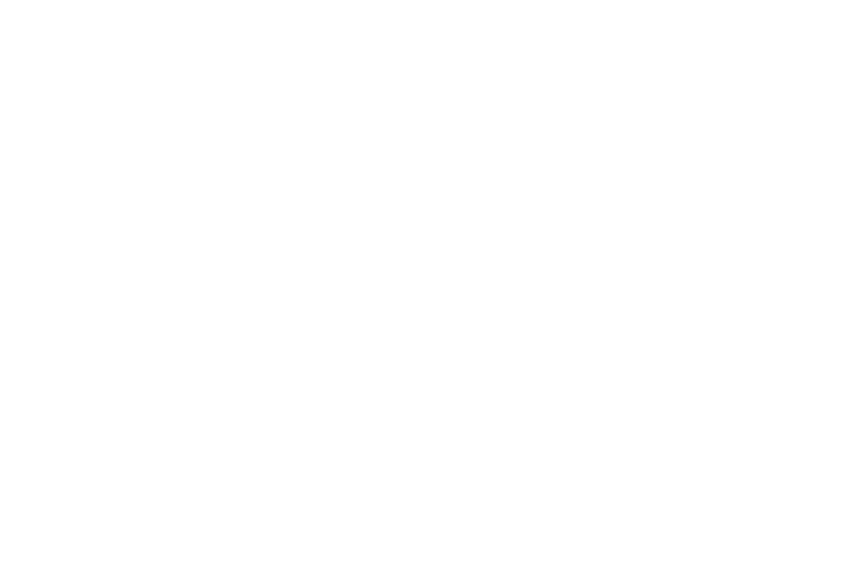

<IPython.core.display.Javascript object>


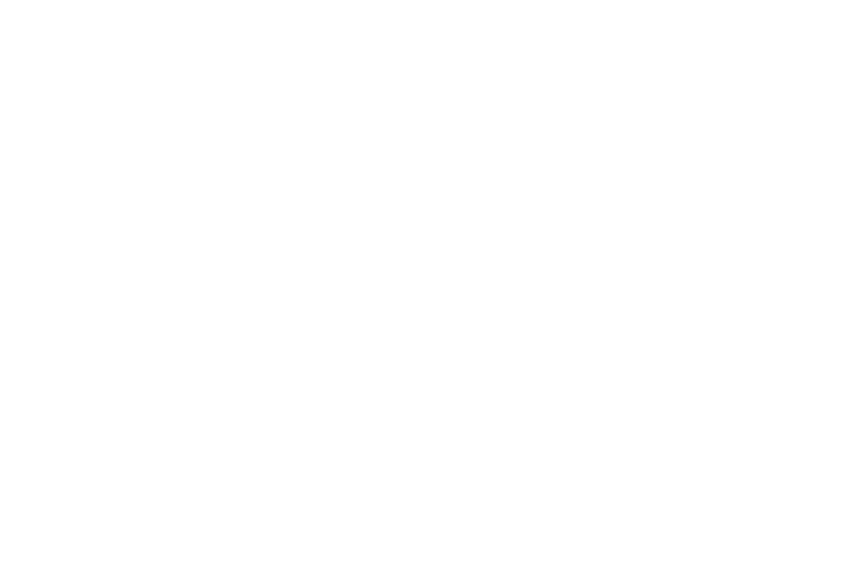

<IPython.core.display.Javascript object>


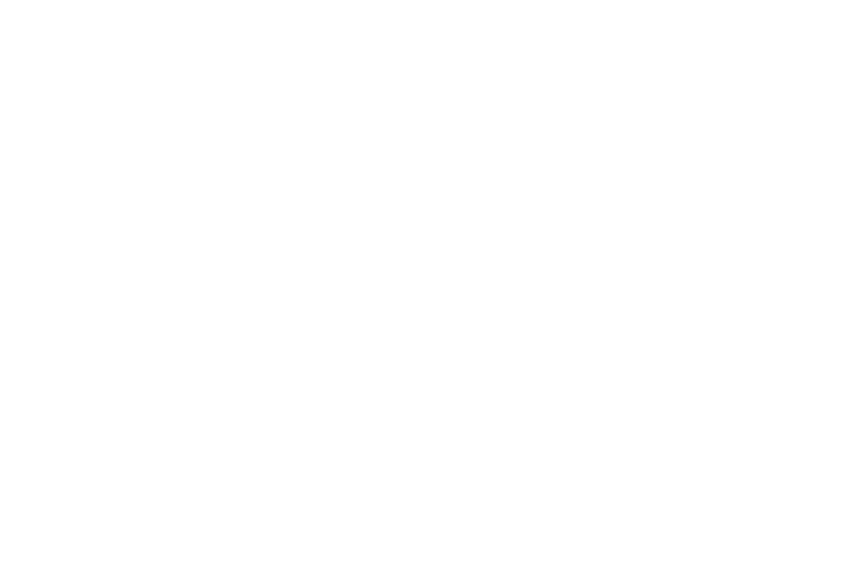

<IPython.core.display.Javascript object>


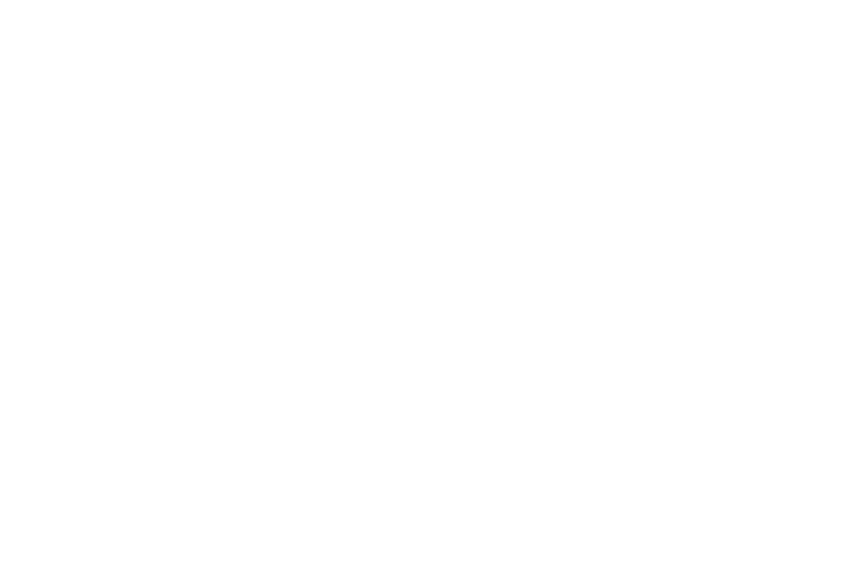

In [33]:
%matplotlib notebook
# quick visalisation of measurements
scan = np.load(output)

# grap the quantities from file
p_density = scan[:,0]
a_density = scan[:,2]
p_vel = scan[:, 4]
a_vel = scan[:, 6]

plt.figure()
plt.ylabel("speed")
plt.xlabel("density")
plt.plot(p_density, p_vel, marker="x", ls="", label="person")
plt.plot(a_density, a_vel, marker="x", ls="", label="agent")
plt.legend()
plt.show()

plt.figure()
plt.ylabel("flow")
plt.xlabel("density")
plt.plot(p_density, p_vel*p_density,  marker="x", ls="", label="person")
plt.plot(a_density, a_vel*a_density,  marker="x", ls="", label="agent")
plt.legend()
plt.show()

## Append datasets

You can use this code to cobine train/val/test splits of multiple datasets to one big. Load the dataset using the loading procedure from above and append it to the buffer. Repeat until you have all desired datasets. In the end stack all data together and save it as one big dataset.

In [71]:
# initalize a new appedn buffer

t_i_a = []
t_t_a = []
v_i_a = []
v_t_a = []
te_i_a = []
te_t_a = []


In [39]:
# append the current dataset to the buffer
t_i_a.append(train[0])
t_t_a.append(train[1])
v_i_a.append(val[0])
v_t_a.append(val[1])
te_i_a.append(test[0])
te_t_a.append(test[1])

In [40]:
# Stack buffer of train data to one big array
print(len(t_i_a))

t_i_a_n = np.vstack(t_i_a)
t_t_a_n = np.vstack(t_t_a)

v_i_a_n = np.vstack(v_i_a)
v_t_a_n = np.vstack(v_t_a)

te_i_a_n = np.vstack(te_i_a)
te_t_a_n = np.vstack(te_t_a)

#120826,

8


In [42]:
# reformat data to the desired format
train = (t_i_a_n, t_t_a_n)
val = (v_i_a_n, v_t_a_n)
test = (te_i_a_n, te_t_a_n)

# update the parameter dict
dset['date'] = time.ctime()
dset['creator'] = 'zehndiii'
dset['augmentation'] = str([])
dset['name'] = 'test_combine'
param['dataset'] = dset

# generate the file name
sufix = "_nn{}_s{}_vr{}_m{}_vi{}_st{}_d{}".format(dset['neighbors'],
                                 dset['shuffle'],
                                 dset['truth_with_vel'],
                                 dset['mode'],
                                 dset['ret_vel']+dset['nn_vel'], 
                                 dset['step_nr'],
                                 dset['downsample'])

# filename
f_name = PATH2+param['dataset']['name']+sufix+'.h5'

# save the dataset
hd.save_trainingdata(f_name, param, train, val, test)


## Insert static person

In [ ]:
# Get all frames from dataset 
frames = da.data['f'].unique()

In [ ]:

# add three personsn evenly spaced in the middle of the corridor
traj = np.zeros( (frames.shape[0], 2) )
vels = traj.copy()
print(traj.shape)
traj[:, 0] = -100
traj[:, 1] = 90

da.append_person(AGENT_OFFSET-1, frames, traj, vel=vels)
    

traj = np.zeros( (frames.shape[0], 2) )
vels = traj.copy()
print(traj.shape)
traj[:, 0] = 100
traj[:, 1] = 90

da.append_person(AGENT_OFFSET-2, frames, traj, vel=vels)
    
traj = np.zeros( (frames.shape[0], 2) )
vels = traj.copy()
print(traj.shape)
traj[:, 0] = 0
traj[:, 1] = 90

da.append_person(AGENT_OFFSET-3, frames, traj, vel=vels)

In [26]:
PATH_O

'data/Output/test_scan/'